In [34]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import PRNGKeyArray, Float, Array
import seaborn as sns
sns.set_context("talk")

key = jr.key(3)

def mixture_samples(key: PRNGKeyArray, num_samples: int):
    key, *keys = jr.split(key, 3)
    indicies = jr.choice(keys[0], a=2, p=jnp.array((0.3, 0.7)), shape=(num_samples,))
    means = jnp.array([-2,2])
    sigmas = jnp.array([0.2, 1])
    return means[indicies] + sigmas[indicies] * jr.normal(keys[1], shape=(num_samples,))


def diffuse(prev_x: Float[Array, "samples"], key: PRNGKeyArray, alpha: float):
    noise = jr.normal(key=key, shape=(prev_x.shape[-1],))
    return alpha**0.5 * prev_x + (1-alpha)**0.5 * noise



/Users/nsimpson/Code/diffusion-playground/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nsimpson/Code/diffusion-playground/.venv/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/nsimpson/Code/diffusion-playground/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nsimpson/Code/diffusion-playground/.venv/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/nsimpson/Code/diffusion-playground/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex value

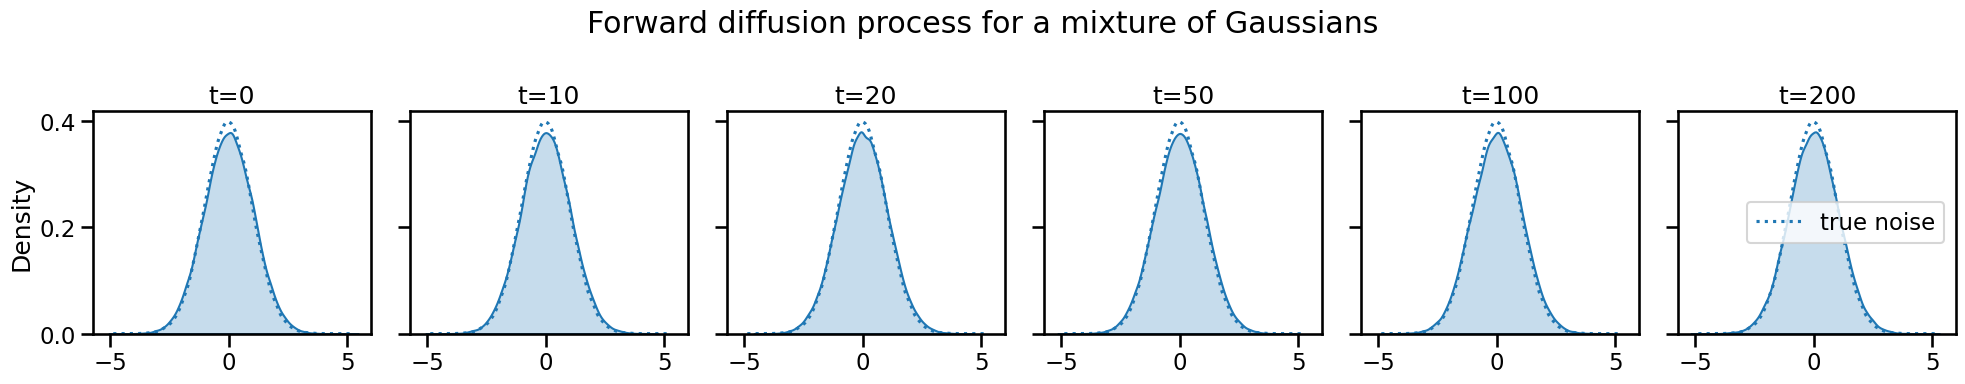

In [43]:
import matplotlib.pyplot as plt

key, samples_key, noise_key = jr.split(key, 3)

samps = mixture_samples(samples_key, 100_000)

fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)

plot_at = [0, 10, 20 ,50, 100, 200]
true_noise = jr.normal(noise_key, shape=(100_000,))

ALPHA_VALUE = 0.97
# plot the diffusion process
for i in range(201):
    key, noise_key = jr.split(key)
    samps = diffuse(samps, noise_key, alpha=ALPHA_VALUE)
    if i in plot_at:
        ax=axs[plot_at.index(i)]
        # also plot a standard normal distribution
        sns.kdeplot(true_noise, label="true noise", ax=ax, linestyle=":")
        ax.set_title(f"t={i}")
        sns.kdeplot(samps, fill=True, ax=ax,)
plt.legend()
plt.suptitle("Forward diffusion process for a mixture of Gaussians")
plt.tight_layout()
plt.show()

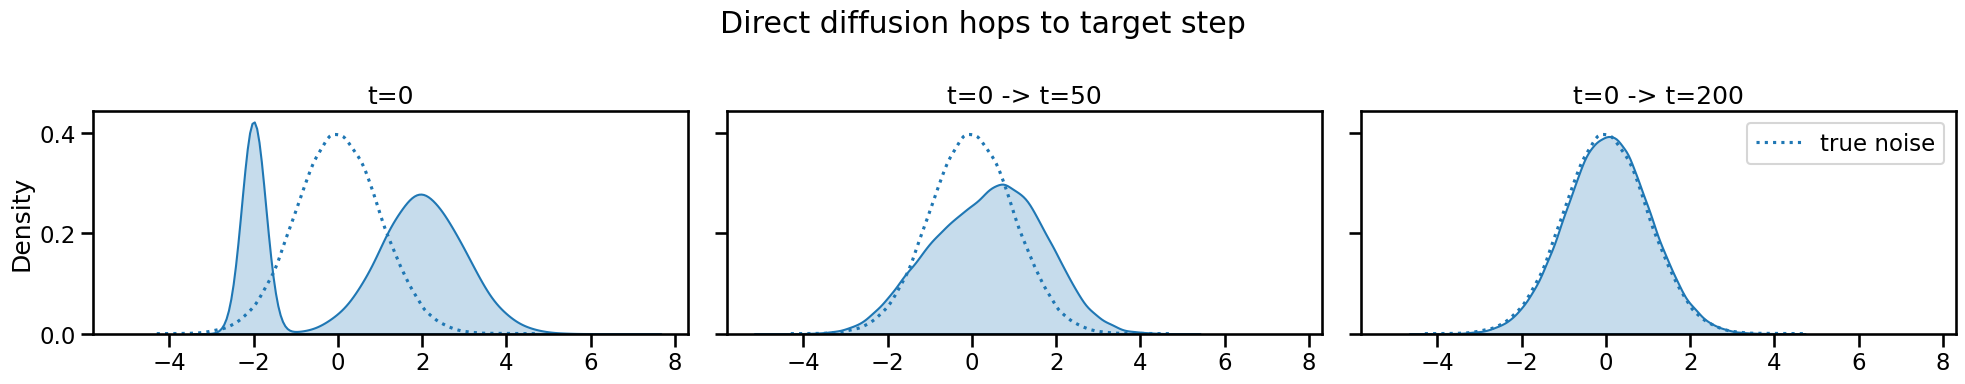

In [12]:
def diffuse_n_times(n: int, prev_x: Float[Array, "samples"], key: PRNGKeyArray, alpha: jnp.array):
    return diffuse(prev_x, key, jnp.prod(alpha[:n]))


















fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
samps = mixture_samples(samples_key, 100_000)
plot_at = [0,  50, 200]
true_noise = jr.normal(noise_key, shape=(100_000,))
# plot the diffusion process
for i in plot_at:
    key, noise_key = jr.split(key)
    new_samps_long_hop = diffuse_n_times(i, samps, noise_key, alpha=ALPHA_VALUE)
    ax=axs[plot_at.index(i)]
    # also plot a standard normal distribution
    sns.kdeplot(true_noise, label="true noise", ax=ax, linestyle=":")
    ax.set_title(f"t=0 -> t={i}" if i!=0 else f"t={i}")
    sns.kdeplot(new_samps_long_hop, fill=True, ax=ax,)
plt.legend()
plt.suptitle("Direct diffusion hops to target step")
plt.tight_layout()
plt.show()

In [17]:
import jax.numpy as jnp
from jaxtyping import Array, Float

def mu_q(
    x_t: Float[Array, "n"], x_0: Float[Array, "n"], t: int, alphas: Float[Array, "t"]
) -> Float[Array, "n"]:
    """
    Compute the mean of q for the reverse process at timestep t, using both barred and unbarred alpha.
    
    Args:
        x_t: The current state at timestep t.
        x_0: The original state at timestep 0.
        t: The current timestep.
        alphas: An array of alpha values for all timesteps.
    
    Returns:
        The mean vector μ_q at timestep t.
    """
    bar_alpha_t = jnp.prod(alphas[:t])
    bar_alpha_t_prev = jnp.prod(alphas[:t-1]) if t > 0 else 1.0
    alpha_t = alphas[t]
    
    return (
        ((1 - bar_alpha_t_prev) * jnp.sqrt(bar_alpha_t)) / (1 - alpha_t) * x_t
        + ((1 - alpha_t) * jnp.sqrt(bar_alpha_t_prev)) / (1 - alpha_t) * x_0
    )

def sigma_q(
    t: int, alphas: Float[Array, "t"]
) -> Float[Array, ""]:
    """
    Compute the standard deviation σ_q(t) for the reverse process at timestep t, using both barred and unbarred alpha.
    
    Args:
        t: The current timestep.
        alphas: An array of alpha values for all timesteps.
    
    Returns:
        The standard deviation σ_q at timestep t.
    """
    bar_alpha_t_prev = jnp.prod(alphas[:t-1]) if t > 0 else 1.0
    alpha_t = alphas[t]
    
    return jnp.sqrt((1 - alpha_t) * (1 - jnp.sqrt(bar_alpha_t_prev)) / (1 - alpha_t))



def reverse(t: int, x_t: Float[Array, "n"], x_0: Float[Array, "n"], alphas: Float[Array, "t"], key: PRNGKeyArray) -> Float[Array, "n"]:
    """
    Compute the reverse process at timestep t. (the cheat way)
    
    Args:
        t: The current timestep.
        x_t: The current state at timestep t.
        x_0: The original state at timestep 0.
        alphas: An array of alpha values for all timesteps.
    
    Returns:
        The reverse process at timestep t.
    """
    mu = mu_q(x_t, x_0, t, alphas)
    sigma = sigma_q(t, alphas)
    
    noise = jr.normal(key=key, shape=(x_t.shape[-1],))
    return mu + sigma * noise


def diffuse_n_times_schedule(n: int, prev_x: Float[Array, "samples"], key: PRNGKeyArray, alphas: Float[Array, "t"]) -> Float[Array, "samples"]:
    """
    Diffuse the state n times using the provided alphas.
    
    Args:
        n: The number of times to diffuse.
        prev_x: The previous state.
        key: The PRNG key.
        alphas: An array of alpha values for all timesteps.
        
    Returns:
        The diffused state.
    """
    return diffuse(prev_x, key, jnp.prod(alphas[:n]))

/var/folders/3k/yt9hwq692kg3qknh2nnj80yh0000gr/T/ipykernel_29863/1629068454.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


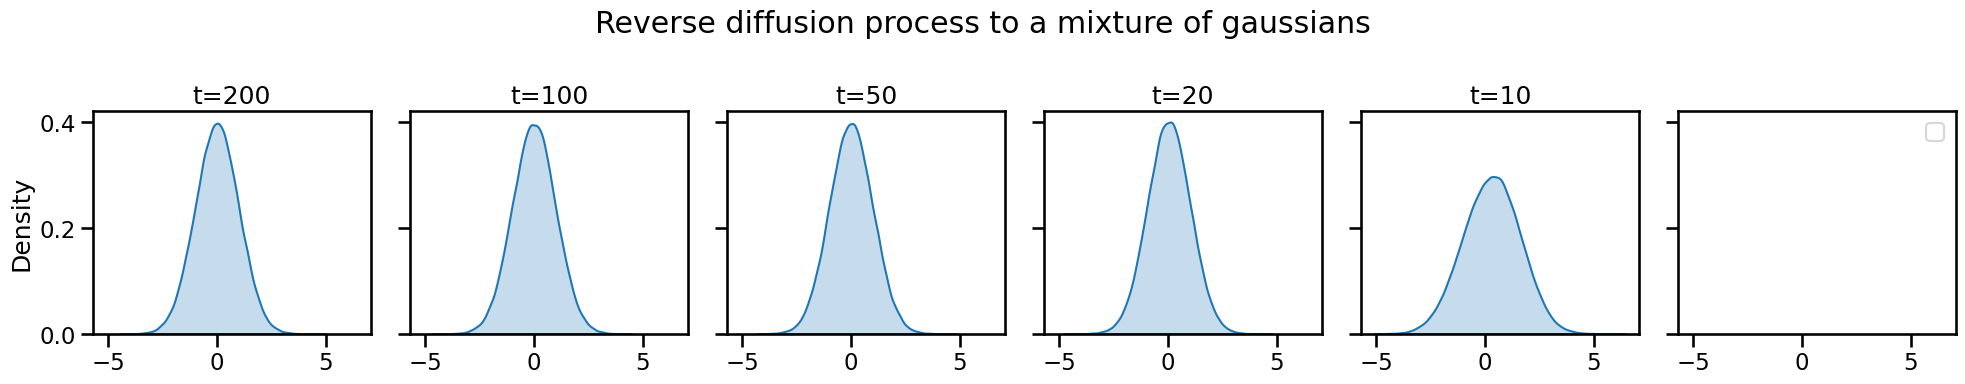

In [27]:
fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)
plot_at = [200, 100, 50, 20, 10, 0]

alphas = jnp.linspace(0.7, 0.9, max(plot_at))

key, samples_key, noise_key = jr.split(key, 3)

samps = mixture_samples(samples_key, 100_000)
reversed_samps = diffuse_n_times_schedule(n=max(plot_at), key=noise_key, prev_x=samps, alphas=alphas)
# plot the diffusion process
for i in range(max(plot_at), min(plot_at), -1):
    key, noise_key = jr.split(key)
    reversed_samps = reverse(x_0=samps, t=i, key=noise_key, x_t=reversed_samps, alphas=alphas)
    if i in plot_at:
        ax=axs[plot_at.index(i)]
        # also plot a standard normal distribution
        # sns.kdeplot(true_noise, label="true noise", ax=ax, linestyle=":")
        ax.set_title(f"t={i}")
        sns.kdeplot(reversed_samps, fill=True, ax=ax,)
plt.legend()
plt.suptitle("Reverse diffusion process to a mixture of gaussians")
plt.tight_layout()
plt.show()

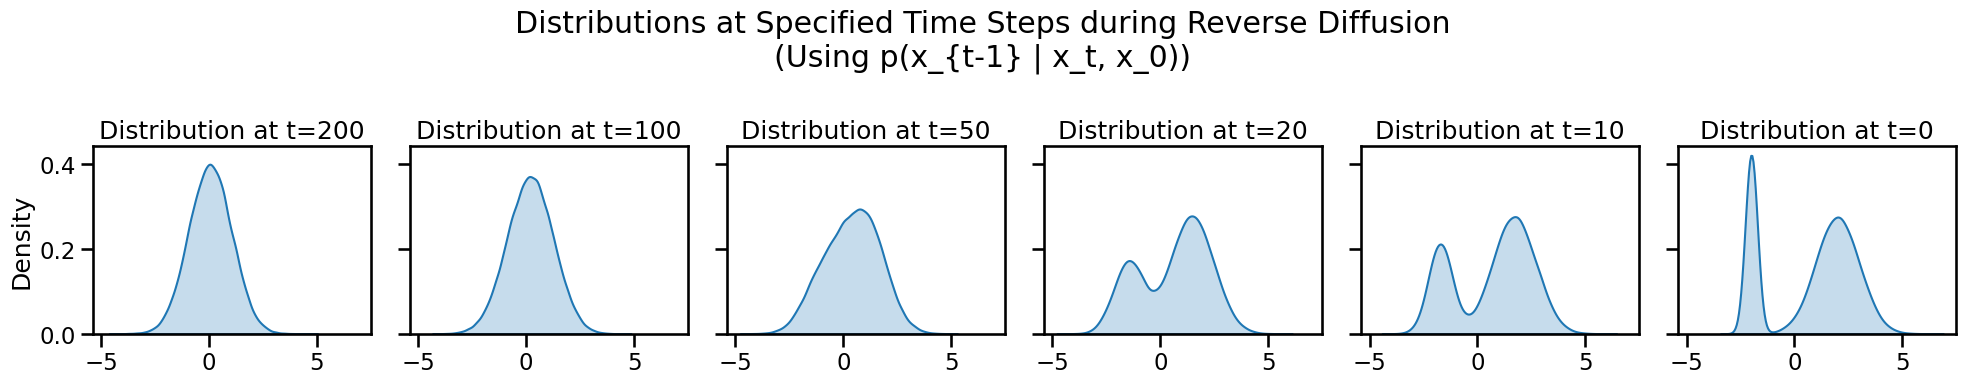

In [33]:
# %%
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import PRNGKeyArray, Float, Array
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

# Seed for reproducibility
key = jr.PRNGKey(0)

# Original mixture parameters
mu_k = jnp.array([-2.0, 2.0])
sigma_k_squared = jnp.array([0.2**2, 1.0**2])
w_k = jnp.array([0.3, 0.7])

ALPHA_VALUE = 0.97  # Diffusion rate
beta_t = 1 - ALPHA_VALUE  # Constant beta_t since alpha_t is constant

def mixture_samples(key: PRNGKeyArray, num_samples: int):
    """
    Generate samples from a Gaussian mixture model.
    """
    key, *keys = jr.split(key, 3)
    indices = jr.choice(keys[0], a=2, p=w_k, shape=(num_samples,))
    means = mu_k
    sigmas = jnp.sqrt(sigma_k_squared)
    return means[indices] + sigmas[indices] * jr.normal(keys[1], shape=(num_samples,))

def diffuse_samples(x0: Float[Array, "samples"], t: int, key: PRNGKeyArray):
    """
    Diffuse x0 to x_t using the forward diffusion process.
    """
    alpha_bar_t = ALPHA_VALUE ** t
    noise = jr.normal(key, shape=x0.shape)
    x_t = jnp.sqrt(alpha_bar_t) * x0 + jnp.sqrt(1 - alpha_bar_t) * noise
    return x_t

def sample_posterior_xtm1_given_xt_x0(x_t: Float[Array, "samples"], x0: Float[Array, "samples"], t: int, key: PRNGKeyArray):
    """
    Sample x_{t-1} from p(x_{t-1} | x_t, x_0).
    """
    alpha_t = ALPHA_VALUE
    beta_t = 1 - alpha_t
    alpha_bar_t = alpha_t ** t
    alpha_bar_t_minus_1 = alpha_t ** (t - 1) if t > 0 else 1.0

    # Mean of the posterior
    coef1 = (jnp.sqrt(alpha_bar_t_minus_1) * beta_t) / (1 - alpha_bar_t)
    coef2 = (jnp.sqrt(alpha_t) * (1 - alpha_bar_t_minus_1)) / (1 - alpha_bar_t)
    posterior_mean = coef1 * x0 + coef2 * x_t

    # Variance of the posterior
    posterior_variance = beta_t * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
    posterior_std = jnp.sqrt(posterior_variance)

    # Sample x_{t-1}
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, shape=x_t.shape)
    x_t_minus_1 = posterior_mean + posterior_std * noise
    return x_t_minus_1, key

def reverse_diffusion_process(num_steps: int, x_T: Float[Array, "samples"], x0: Float[Array, "samples"], key: PRNGKeyArray, save_steps):
    """
    Perform the reverse diffusion process starting from x_T, using x0.
    """
    samples_at_steps = {}
    x_t = x_T
    t = num_steps
    if t in save_steps:
        samples_at_steps[t] = x_t.copy()
    for t in range(num_steps, 0, -1):  # t from num_steps down to 1
        x_t_minus_1, key = sample_posterior_xtm1_given_xt_x0(x_t, x0, t, key)
        if (t - 1) in save_steps:
            samples_at_steps[t - 1] = x_t_minus_1.copy()
        x_t = x_t_minus_1
    return samples_at_steps

# Generate original samples from the mixture
key, samples_key = jr.split(key)
num_samples = 100_000
x0_samples = mixture_samples(samples_key, num_samples)

# Diffuse x0 to x_T
num_steps = 200
key, diffusion_key = jr.split(key)
x_T = diffuse_samples(x0_samples, num_steps, diffusion_key)

# Perform reverse diffusion and collect samples at specified time steps
save_steps = [200, 100, 50, 20, 10, 0]  # Time steps to save
key, reverse_key = jr.split(key)
samples_at_steps = reverse_diffusion_process(num_steps, x_T, x0_samples, reverse_key, save_steps)

# Plotting the distributions at specified time steps
fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)
axs = axs.flatten()

for idx, t in enumerate(sorted(save_steps, reverse=True)):
    sns.kdeplot(samples_at_steps[t], fill=True, ax=axs[idx], label=f"t={t}")
    axs[idx].set_title(f"Distribution at t={t}")
    # axs[idx].legend()

plt.suptitle("Distributions at Specified Time Steps during Reverse Diffusion\n(Using p(x_{t-1} | x_t, x_0))")
plt.tight_layout()
plt.show()


In [ ]:
key = jr.key(4)
key, *keys = jr.split(key, 3)

def sample_three_functions(keys):
    jr.normal(keys[0], (3,))